# Классификация текстов с помощью модели BERT



Рассмотрим задачу классификации текстов с использованием BERT. 

Источник изложения: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

В качестве данных будем использовать отзывы на приложения в Google Play. 
Данные будут содержать тексты отзывов и оценки, которые пользователи поставили приложениям (от 1 до 5).

Наша задача -- построить модель, которая сможет предсказать оценку пользователя на основе текста его отзыва.

Для решения этой задачи мы будем использовать модель BERT, основанную на архитектуре Transformer. 

Мы научимся:
- Обрабатывать данные для модели BERT
- Дообучать модель BERT на нашем наборе данных
- Использовать обученную модель для оценки текстов

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 110.0 MB/s eta 0:00:00


Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 89.7MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 22.4MB/s]


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
df = pd.read_csv("reviews.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

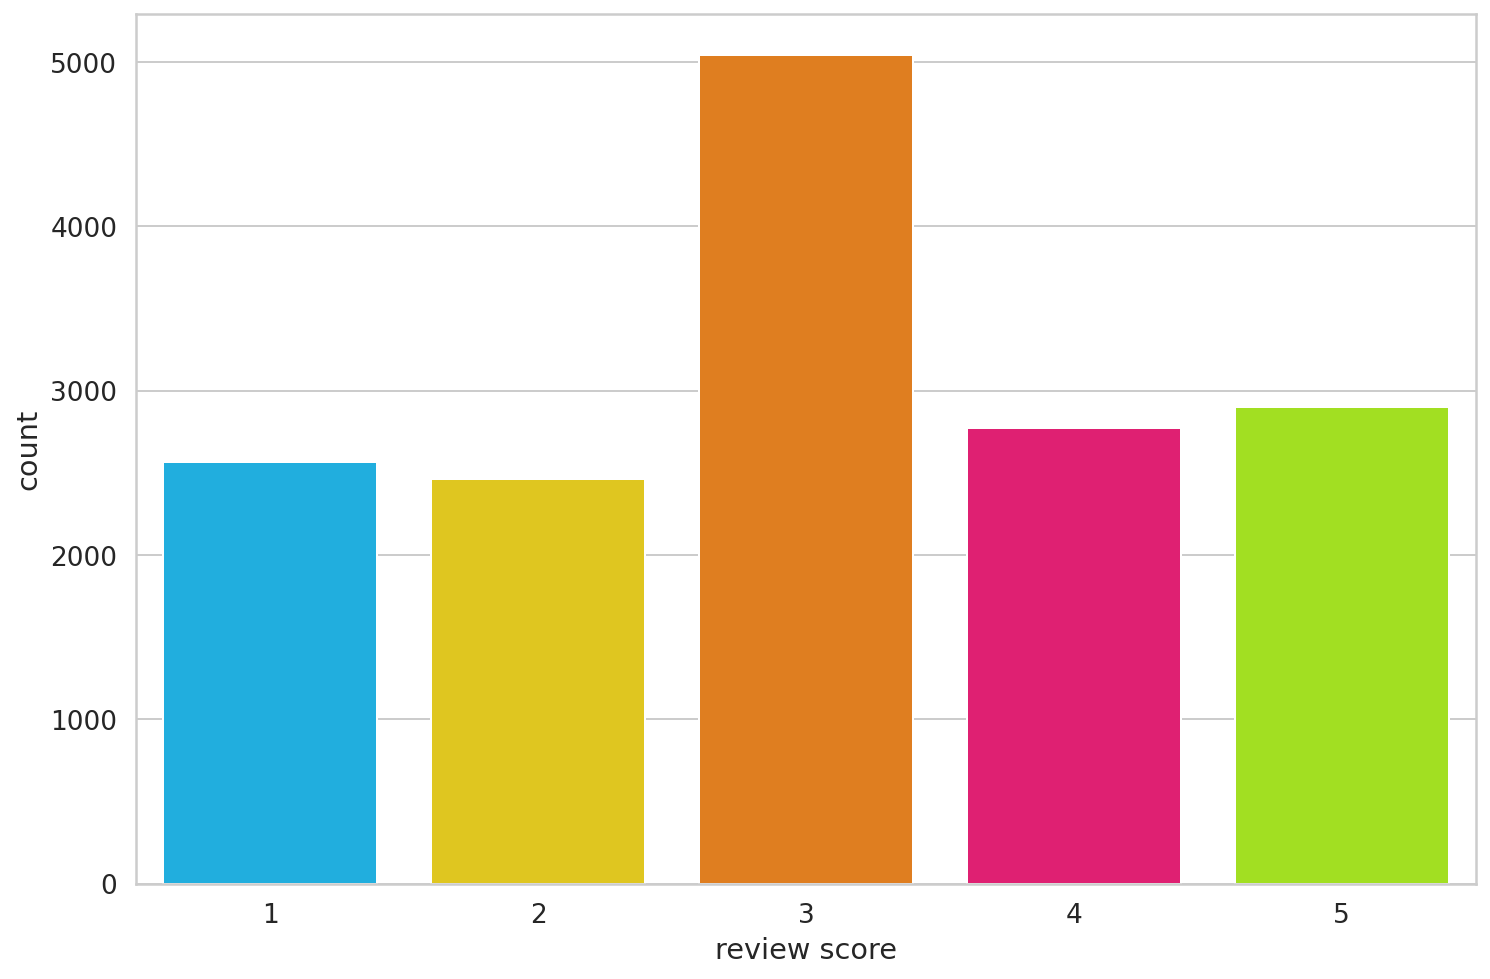

In [ ]:
sns.countplot(x=df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

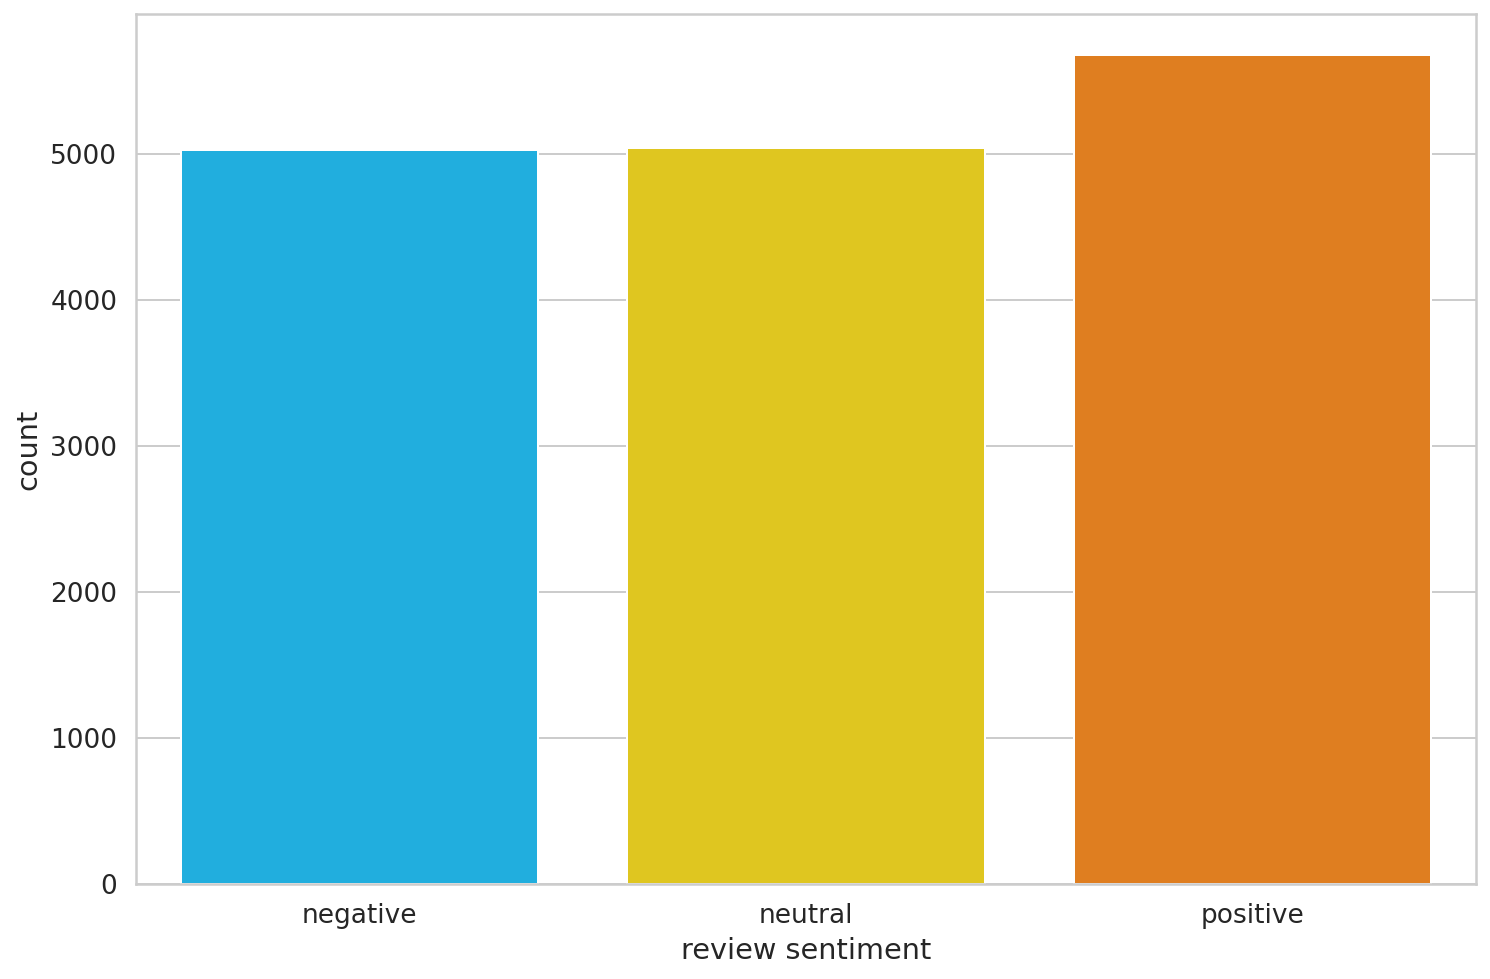

In [ ]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.

Будем использовать модели токенизации из библиотеки Hugging Face.

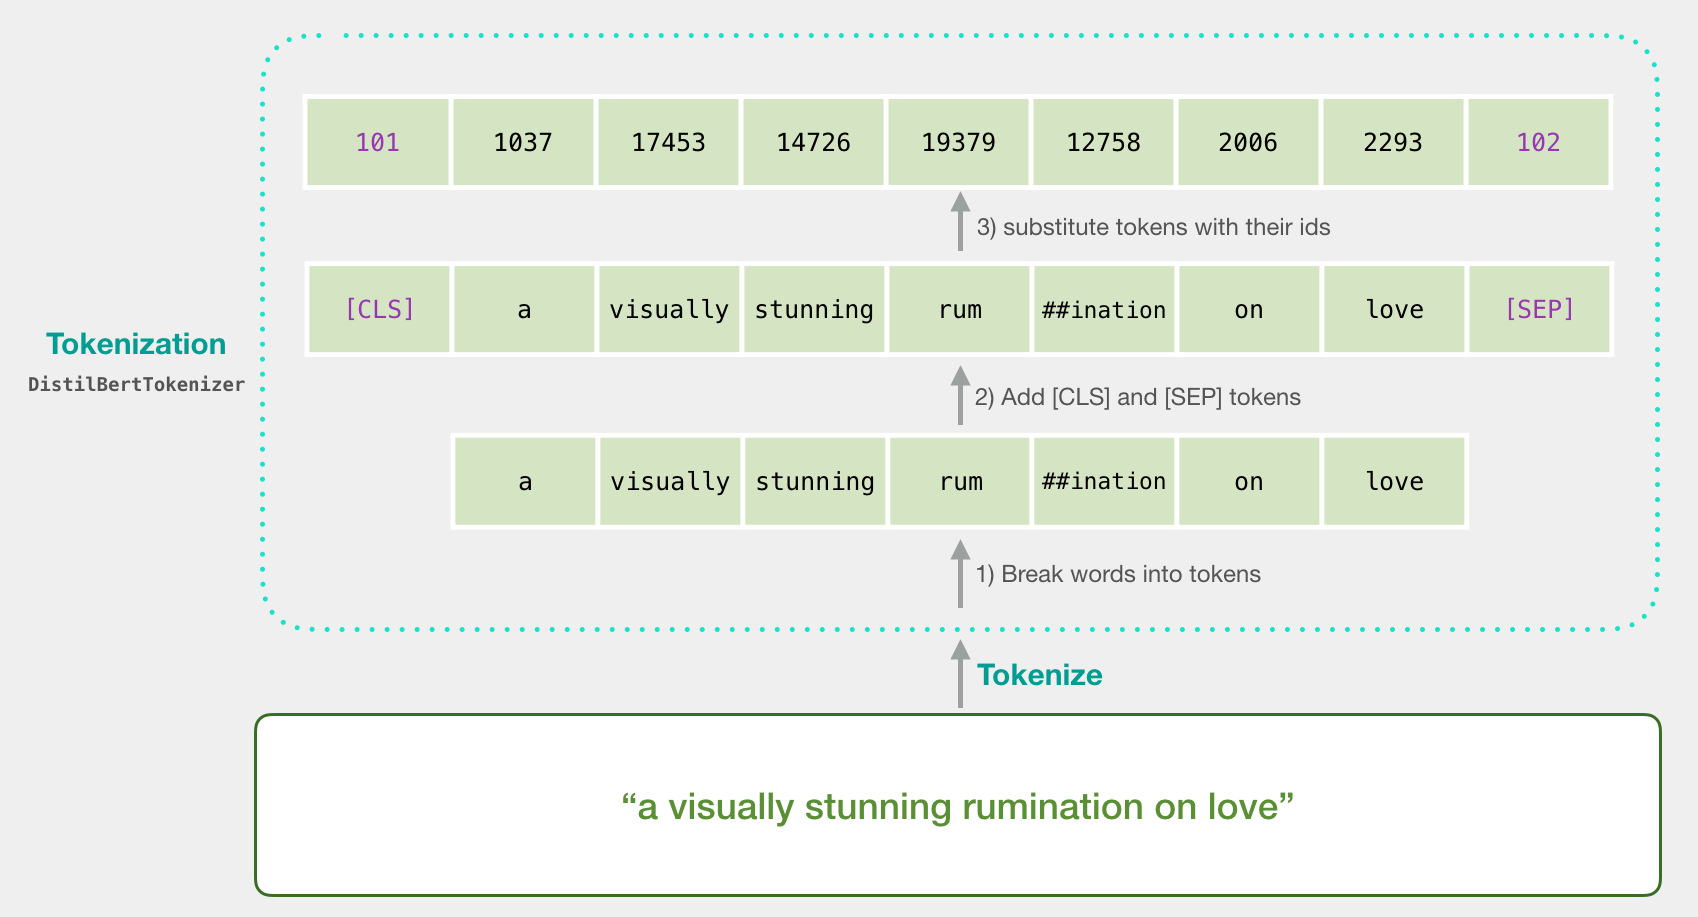

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokenized_sample = tokenizer(sample_txt)
token_ids = tokenized_sample['input_ids']
tokens = tokenizer.convert_ids_to_tokens(token_ids)
attention_mask = tokenized_sample['attention_mask']

print(f'Sentence: {sample_txt}')
print(f'Token IDs: {token_ids}')
print(f'Tokens: {tokens}')
print(f'Attention mask: {attention_mask}')

Sentence: When was I last outside? I am stuck at home for 2 weeks.
Token IDs: [101, 1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119, 102]
Tokens: ['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]']
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokenized_sample = tokenizer(sample_txt, padding='max_length', truncation=True, max_length=32)
token_ids = tokenized_sample['input_ids']
tokens = tokenizer.convert_ids_to_tokens(token_ids)
attention_mask = tokenized_sample['attention_mask']

print(f'Sentence: {sample_txt}')
print(f'Token IDs: {token_ids}')
print(f'Tokens: {tokens}')
print(f'Attention mask: {attention_mask}')

Sentence: Один человек
Token IDs: [101, 461, 28396, 17424, 17127, 498, 19692, 28400, 24625, 19692, 28399, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['[CLS]', 'О', '##д', '##и', '##н', 'ч', '##е', '##л', '##ов', '##е', '##к', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



##  Специальные токены

`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Кроме того, существует специальный токен для неизвестных слов, которые не встречались в обучающей выборке

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Для работы с PyTorch нам нужно использовать тензоры

In [ ]:
encoding = tokenizer(
  sample_txt,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Установим максимальную длину последовательности равной 160

In [ ]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer(
      review,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
df_train = df_train[:1000]

In [ ]:
df_train.shape

(1000, 12)

In [ ]:
df_val = df_val[:100]

In [ ]:
df_test = df_test[:100]

Для обработки данных нам также нужно будет создать итераторы 
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data

{'review_text': ["You can't have your to do list as notifications",
  "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.",
  '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.',
  'Love it so far. Wish it had a widget for Android though.',
  "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way 

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Попробуем использовать эту модель 

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

Модель возвращает вектора для каждого токена в документе и вектор для токена [CLS], в котором хранится векторное представление всего документа

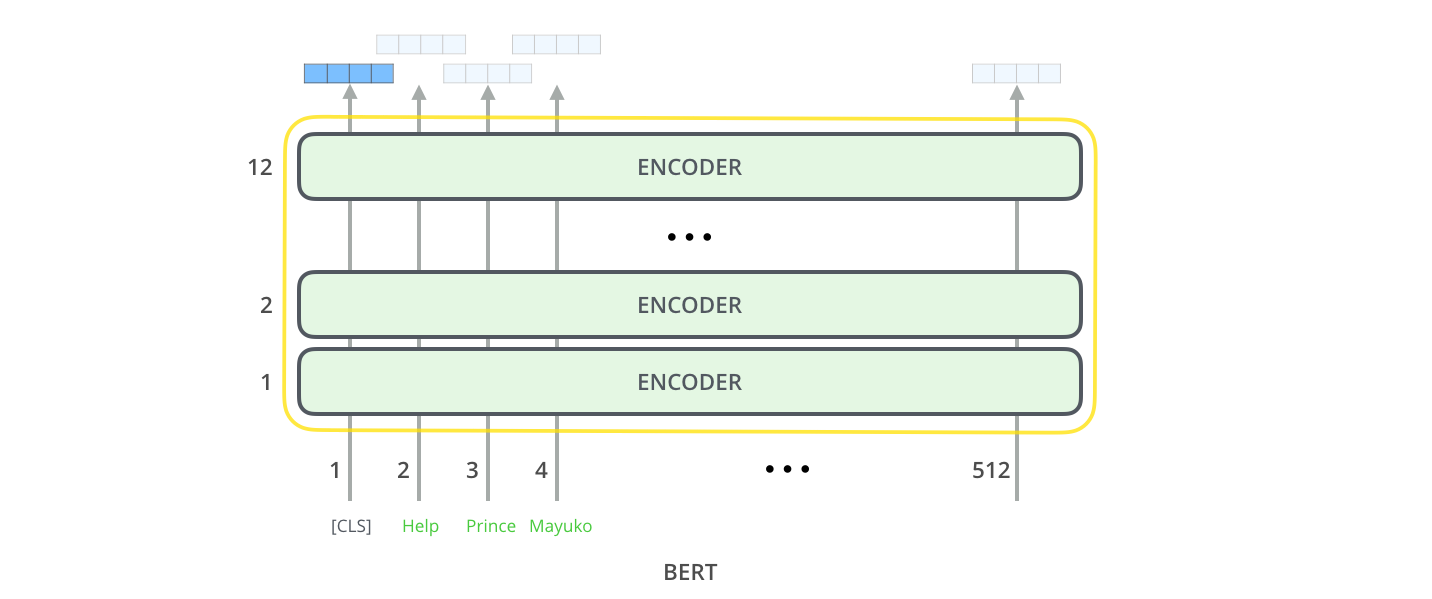

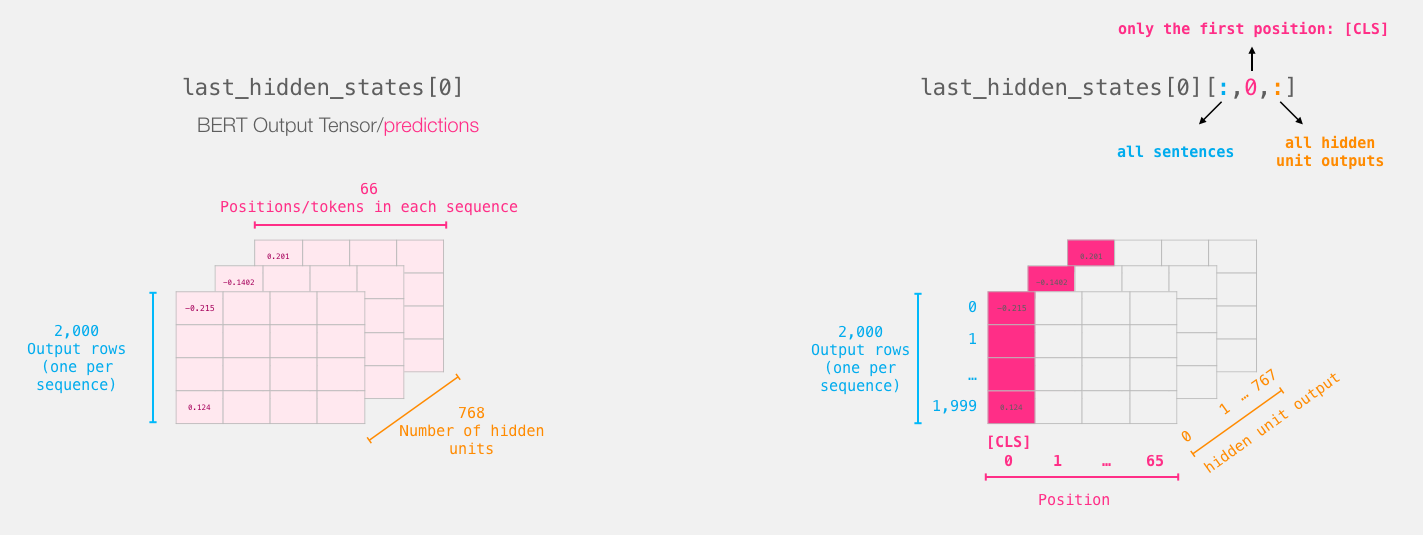

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
last_hidden_state = outputs['last_hidden_state']


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [ ]:
df.loc[16]['content']

"Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service."

In [ ]:
sample_txt = df.loc[16]['content']

In [ ]:
encoding = tokenizer(
  sample_txt,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt'
)

In [ ]:
encoding['input_ids']

tensor([[  101, 23320,   112,   189,  1256,  1383,  1146,  1141,  1423, 10993,
         15656,  1443,  1217,  2320,  1106,  2653,  7868, 16759,   119,  3949,
          1240, 24007,  1289,  1228,  1122,  1260,  1964,   119,  1135,   112,
           188,   102]])

In [ ]:
model_res = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state = model_res['last_hidden_state']

last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooler_output = model_res['pooler_output']

pooler_output.shape

torch.Size([1, 768])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', "'", 's', '[SEP]']


In [ ]:
word_index = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')
word_index

17

In [ ]:
emb0 = last_hidden_state[0, word_index]
emb0.shape

torch.Size([768])

In [ ]:
df.loc[338]['content']

'Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for'

In [ ]:
sample_txt = df.loc[338]['content']
encoding = tokenizer(
  sample_txt,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt'
)

model_res = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)
last_hidden_state = model_res['last_hidden_state']
pooler_output = model_res['pooler_output']


In [ ]:
word_index = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('premium')

In [ ]:
emb1 = last_hidden_state[0, word_index]
emb1.shape

torch.Size([768])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity([
    emb0.detach().cpu().numpy(),
    emb1.detach().cpu().numpy()])

array([[0.99999976, 0.72586256],
       [0.72586256, 0.99999946]], dtype=float32)

#### Классификатор

Будем использовать модель BERT с линейным слоем для классификации.

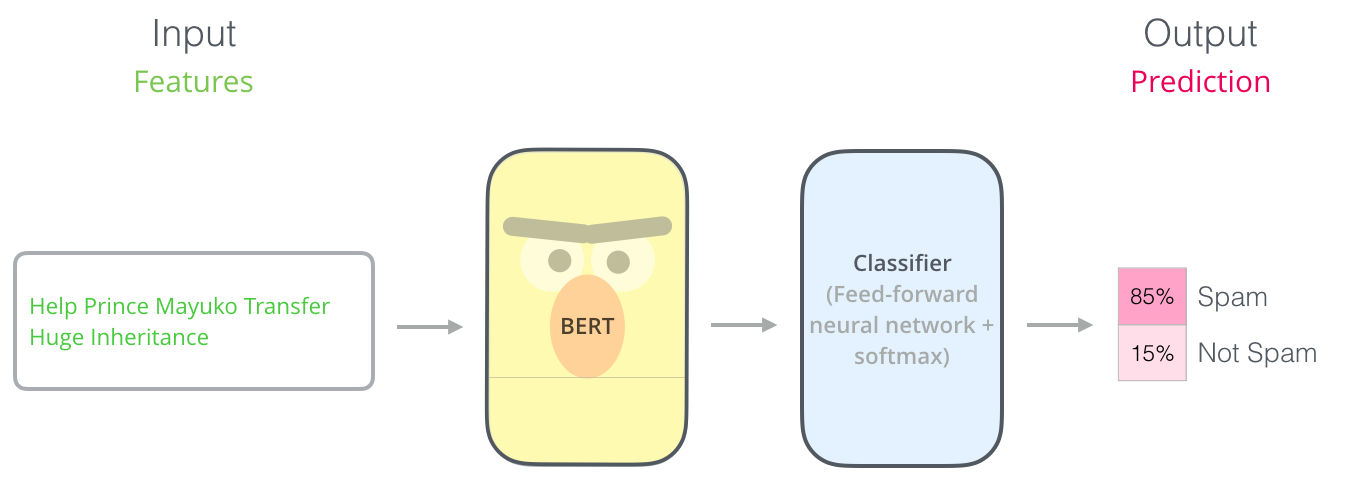

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Перенесем на GPU один из наших батчей (для примера).

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Чтобы получить вероятности классов, мы применим SoftMax к выходу модели.

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Обучение модели

Для дообучения модели будем использовать оптимайзер [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.9619434632006145 accuracy 0.502
Val   loss 0.9087384683745248 accuracy 0.56

Epoch 2/3
----------
Train loss 0.6789082884788513 accuracy 0.7000000000000001
Val   loss 0.8939387968608311 accuracy 0.59

Epoch 3/3
----------
Train loss 0.4535577595233917 accuracy 0.8290000000000001
Val   loss 0.9552683489663261 accuracy 0.61

CPU times: user 56 s, sys: 27.7 s, total: 1min 23s
Wall time: 1min 27s



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

NameError: ignored

In [ ]:
# model.load_state_dict(torch.load('best_model_state.bin'))

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.66

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.55      0.69      0.61        26
     neutral       0.58      0.53      0.55        36
    positive       0.85      0.76      0.81        38

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.67      0.66      0.66       100



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

---



Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

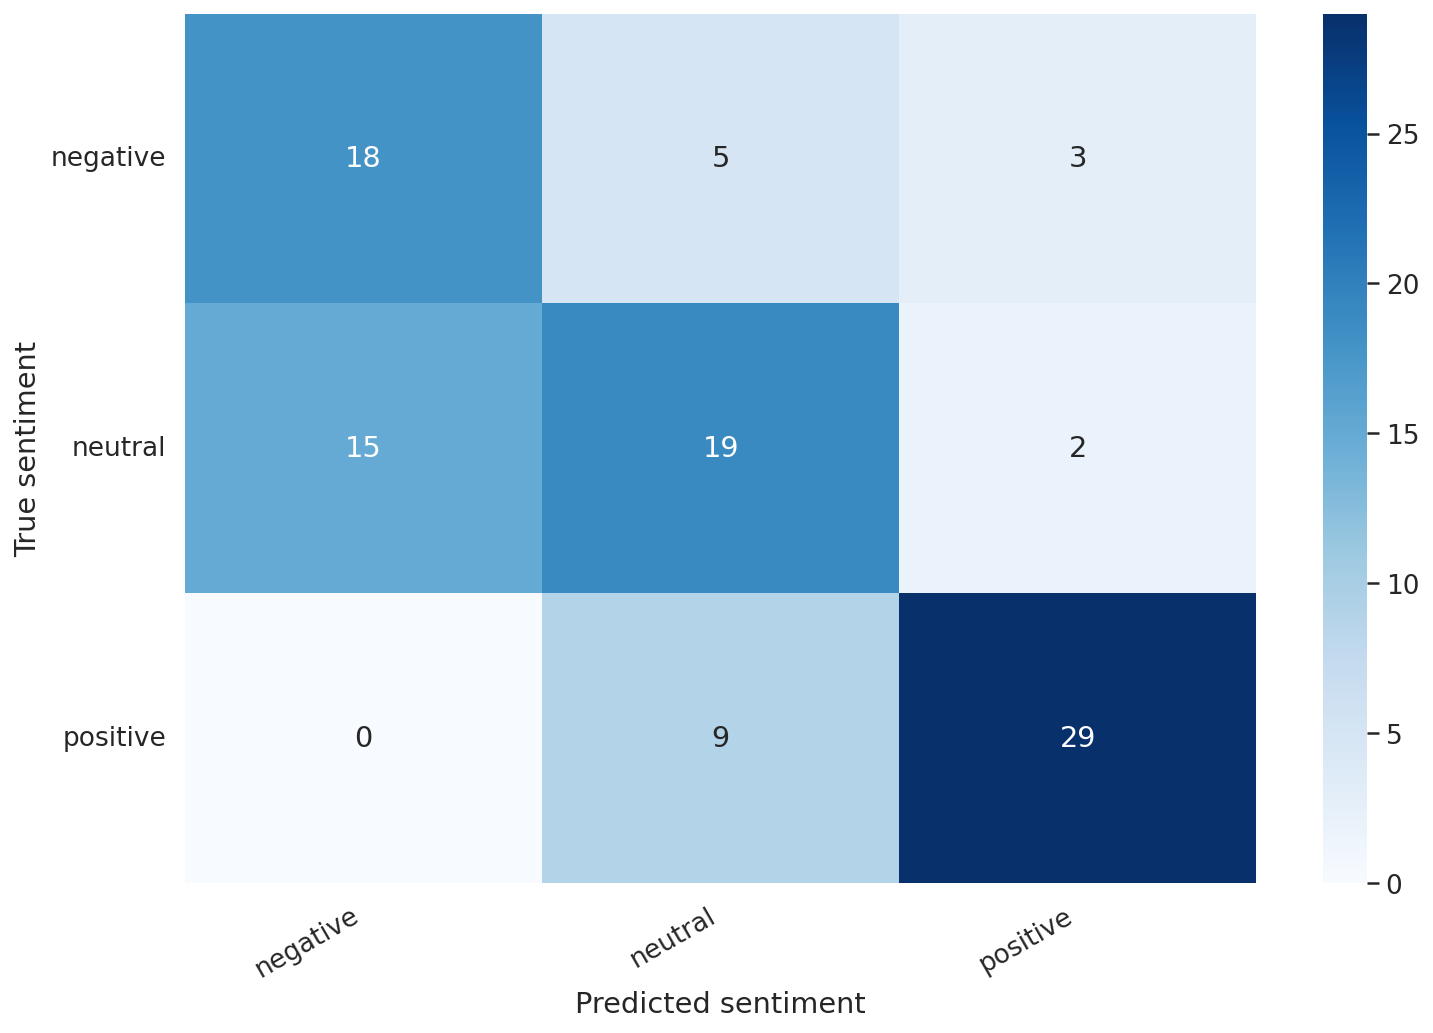

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer(
  review_text,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt'
)


Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Как изменились эмбеддинги?

Посмотрим на эмбеддинги расмотренных ранее слов subscription и premium после дообучения модели BERT.


In [ ]:
sample_txt = df.loc[16]['content']
encoding = tokenizer(
  sample_txt,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt'
)
encoding = encoding.to(device)
last_hidden_state = model.bert(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)["last_hidden_state"]
idx0 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')
emb0 = last_hidden_state[0, idx0]

In [ ]:
sample_txt = df.loc[338]['content']
encoding = tokenizer(
  sample_txt,
  max_length=32,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt'
)
encoding = encoding.to(device)
last_hidden_state = model.bert(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)["last_hidden_state"]
idx1 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('premium')
emb1 = last_hidden_state[0, idx1]

In [ ]:
cosine_similarity([
    emb0.detach().cpu().numpy(),
    emb1.detach().cpu().numpy()])

array([[1.0000001, 0.7501296],
       [0.7501296, 1.       ]], dtype=float32)

Можно увидеть, что в результате дообучения слова стали ближе друг к другу.

## Используем инструменты HuggingFace для классификации

Библиотека HuggingFace предоставляет инструменты, которые упрощают обучение и оценкиу моделей, выложенных в репозиторий библиотеки. Рассмотрим эти инструменты на примере задачи анализа тональности. Будем обучать и оценивать модели на датасете imdb, состоящем из отзывов пользователей о фильмах. 

Оригинал: https://huggingface.co/docs/transformers/v4.25.1/en/training

Для загрузки датасета воспользуемся библиотекой datasets, реализованной HuggingFace. Данная библиотека предоставляет возможность быстро и удобно скачивать различные бенчмарки: https://huggingface.co/datasets

Для удобного подсчета метрик при обучении воспользуемся библиотекой evaluate, тоже от HuggingFace.

In [ ]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb_dataset["train"]["text"][:10]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [ ]:
imdb_dataset["train"]["label"][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Токенизируем данные

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = imdb_dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Сократим количество примеров, чтобы процесс обучения был быстрее.

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

In [ ]:
import numpy as np
import evaluate

clf_metrics = evaluate.combine(["accuracy", "precision", "recall"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels)

Зададим параметры обучения с помощью TrainingArguments:

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='results',
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    warmup_steps=10,
)

Инициализируем модель и запустим fine-tune ее с помощью модуля Trainer. В данном модуле будет автоматически происходить итерация по эпохам, батчам, рассчет функции потерь и градиентов, ничего этого больше руками прописывать не нужно!

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall
50,No log,0.382744,0.855000,0.892449,0.799180
100,No log,0.333106,0.877000,0.850288,0.907787
150,No log,0.467768,0.866000,0.819495,0.930328
200,No log,0.484548,0.867000,0.820976,0.930328
250,No log,0.477986,0.887000,0.868369,0.905738


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to results/checkpoint-50
Configuration saved in results/checkpoint-50/config.json
Model weights saved in results/checkpoint-50/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to results/checkpoint-100
Configuration saved in results/checkpoint-100/config.json
Model weights saved in results/checkpoint-100/pytorch_model.bin
T

TrainOutput(global_step=252, training_loss=0.29556598360576325, metrics={'train_runtime': 583.6044, 'train_samples_per_second': 6.854, 'train_steps_per_second': 0.432, 'total_flos': 1052472569856000.0, 'train_loss': 0.29556598360576325, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'eval_loss': 0.33310550451278687,
 'eval_accuracy': 0.877,
 'eval_precision': 0.8502879078694817,
 'eval_recall': 0.9077868852459017,
 'eval_runtime': 35.5476,
 'eval_samples_per_second': 28.131,
 'eval_steps_per_second': 0.45,
 'epoch': 4.0}

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Задания

1. Посмотрите на другие изменения эмбеддингов после дообучения модели BERT.
2. Попробуйте использовать другую предобученную модель BERT (например, bert-base-uncased) и сравните качество классификации. Модели Transformers: https://huggingface.co/transformers/pretrained_models.html
3. Попробуйте добавить аугментацию для восстановления баланса классов и обучить классификатор, сравните результаты с базовой версией модели.

Для аугментации можно попробовать использовать библиотеку [nlpaug](https://github.com/makcedward/nlpaug).

In [ ]:
!pip install torch>=1.6.0 transformers>=3.0.2

In [ ]:
!pip install nlpaug

In [ ]:
import nlpaug.augmenter.word as naw

aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='substitute')


In [ ]:
augmented_text = aug.augment('tell me the story about your life')
augmented_text

## Итоги

На этом занятии мы научились использовать модель BERT для классификации текстов по тональности.

Мы научились обрабатывать исходные тексты так, чтобы их можно было использовать для обучения модели BERT.

Мы построили собственный классификатор с помощью библиотеки Huggig Face и дообучили его на данных отзывов на приложения Google Play.

На следующих занятиях мы рассмотрим другие задачи NLP, которые можно решать с помощью моделей, основанных на архитектуре Transformer.